# Fruit Classification: Mora or Uchua

## Imports

In [81]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random
import os
import glob

import torch
import torch.nn as nn 
from torch import optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
from pillow_heif import register_heif_opener
import cv2

%matplotlib inline

## Converting images to correct format

In [31]:
def heic2jpg(heic_dir, jpg_dir):
    register_heif_opener()
    heic_files = [image for image in os.listdir(heic_dir) if '.heic' in image]
    
    for image in heic_files:
        tmp_img = Image.open(os.path.join(heic_dir, image))
        jpg_image = image.replace('.heic', '.jpg')
        if not os.path.exists(jpg_dir):
            os.makedirs(jpg_dir, exist_ok=True)
        tmp_img.save(os.path.join(jpg_dir, jpg_image))

In [32]:
# heic2jpg('fruits/mora', 'fruits/mora_jpg')

In [33]:
# heic2jpg('fruits/uchua', 'fruits/uchua_jpg')

## Resizing images

In [6]:
def resize_images(image_dir, dim):

    image_dir_paths = [image for image in os.listdir(image_dir) if image.endswith('.jpg')]
    for image_path in image_dir_paths:
        # opening image
        image = cv2.imread(os.path.join(image_dir, image_path))
        # resizing image
        resized_image = cv2.resize(image, [dim, dim])
        # plt.imshow(resized_image)
        # plt.show()
        # saving image
        cv2.imwrite(os.path.join(image_dir, image_path), resized_image)



In [34]:
# mora
# resize_images('fruits/mora_jpg/', 512)
# # uchua
# resize_images('fruits/uchua_jpg/', 512)


## Model definition

PyTorch requires us to define a Class or to use the model hub. We can do both:

In [82]:
class PretrainedResNet(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedResNet, self).__init__()
        self.resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

## Dataset definition

### Define Transforms

In [83]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=512),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=512, width=512),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=512),
        A.CenterCrop(height=512, width=512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [84]:
train_data_path = os.path.join('output', 'train')
test_data_path = os.path.join('output','test')

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))


train_image_path example:  output/train/mora/IMG_2428.jpg
class example:  uchua
Train size: 127
Valid size: 32
Test size: 69


In [161]:
def load_image_paths(train_data_path, test_data_path):
    train_image_paths = [] # to store image paths in a list
    classes = [] # to store class values

    # 1. Get all the paths from train_data_path and append image paths and class to respective lists
    for data_path in glob.glob(train_data_path + '/*'):
        classes.append(data_path.split('/')[-1]) 
        train_image_paths.append(glob.glob(data_path + '/*'))

    train_image_paths = list(flatten(train_image_paths))
    random.shuffle(train_image_paths)

    print('train_image_path example:', train_image_paths[0])
    print('class example:', classes[0])

    # 2. Split train valid from train paths (80,20)
    train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]

    # 3. Create the test_image_paths
    test_image_paths = []
    for data_path in glob.glob(test_data_path + '/*'):
        test_image_paths.append(glob.glob(data_path + '/*'))

    test_image_paths = list(flatten(test_image_paths))

    print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

    return train_image_paths, valid_image_paths, test_image_paths, classes


# Usage:
train_data_path = os.path.join('output', 'train')
test_data_path = os.path.join('output', 'test')

train_image_paths, valid_image_paths, test_image_paths, classes = load_image_paths(train_data_path, test_data_path)


train_image_path example: output/train/mora/IMG_2070.jpg
class example: uchua
Train size: 127
Valid size: 32
Test size: 69


In [85]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key, value in idx_to_class.items()}

In [162]:
class_to_idx

{'uchua': 0, 'mora': 1}

In [86]:
class_to_idx

{'uchua': 0, 'mora': 1}

In [163]:
class FruitDataset(Dataset):

    def __init__(self, image_paths, transforms=False):
        self.image_paths = image_paths
        self.idx_to_class = {i:j for i, j in enumerate(['uchua', 'mora'])}
        self.class_to_idx = {value:key for key, value in self.idx_to_class.items()}
        self.transform = transforms
        
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = self.class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label
    
train_dataset = FruitDataset(train_image_paths, train_transforms)
valid_dataset = FruitDataset(valid_image_paths, test_transforms)
test_dataset = FruitDataset(test_image_paths, test_transforms)
    

In [164]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 512, 512])
The label for 50th image in train dataset:  1


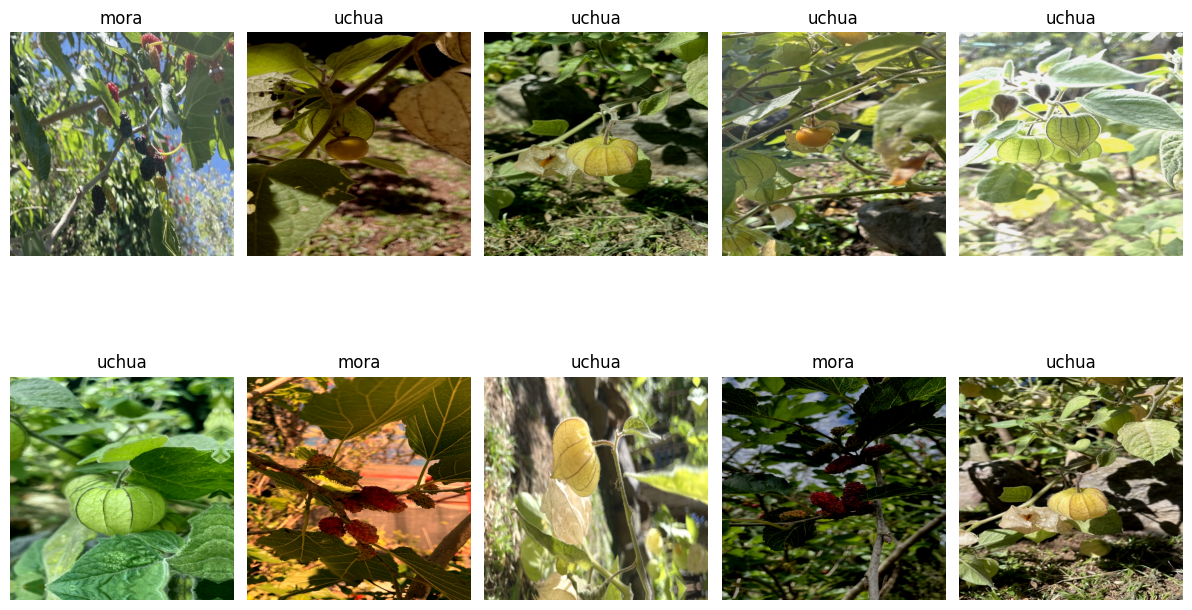

In [42]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(dataset))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

## DataLoaders

In [89]:
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=16, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=True
)

## Training Loop

In [90]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_accuracy = 0.0
    best_model_weights = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / total_predictions
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")
        
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            best_model_weights = copy.deepcopy(model.state_dict())
        
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        
        with torch.no_grad():
            for val_images, val_labels in valid_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                
                val_running_loss += val_loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total_predictions += val_labels.size(0)
                val_correct_predictions += (val_predicted == val_labels).sum().item()
        
        val_epoch_loss = val_running_loss / len(valid_loader.dataset)
        val_epoch_accuracy = val_correct_predictions / val_total_predictions
        
        print(f"Validation Loss: {val_epoch_loss:.4f} - Validation Accuracy: {val_epoch_accuracy:.4f}")
        
        scheduler.step()
    
    print("Training complete!")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")
    
    model.load_state_dict(best_model_weights)
    return model

In [91]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initializing the model
num_classes = len(classes)
model = PretrainedResNet(num_classes)
model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Epochs
num_epochs = 5

trained_model = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/5 - Loss: 0.5467 - Accuracy: 0.7087
Validation Loss: 0.0811 - Validation Accuracy: 1.0000
Epoch 2/5 - Loss: 0.1794 - Accuracy: 0.9449
Validation Loss: 0.0033 - Validation Accuracy: 1.0000
Epoch 3/5 - Loss: 0.0822 - Accuracy: 0.9685
Validation Loss: 0.0006 - Validation Accuracy: 1.0000
Epoch 4/5 - Loss: 0.0901 - Accuracy: 0.9685
Validation Loss: 0.0068 - Validation Accuracy: 1.0000
Epoch 5/5 - Loss: 0.1237 - Accuracy: 0.9370
Validation Loss: 0.0010 - Validation Accuracy: 1.0000
Training complete!
Best Validation Accuracy: 0.9685


## Test model on TestLoader

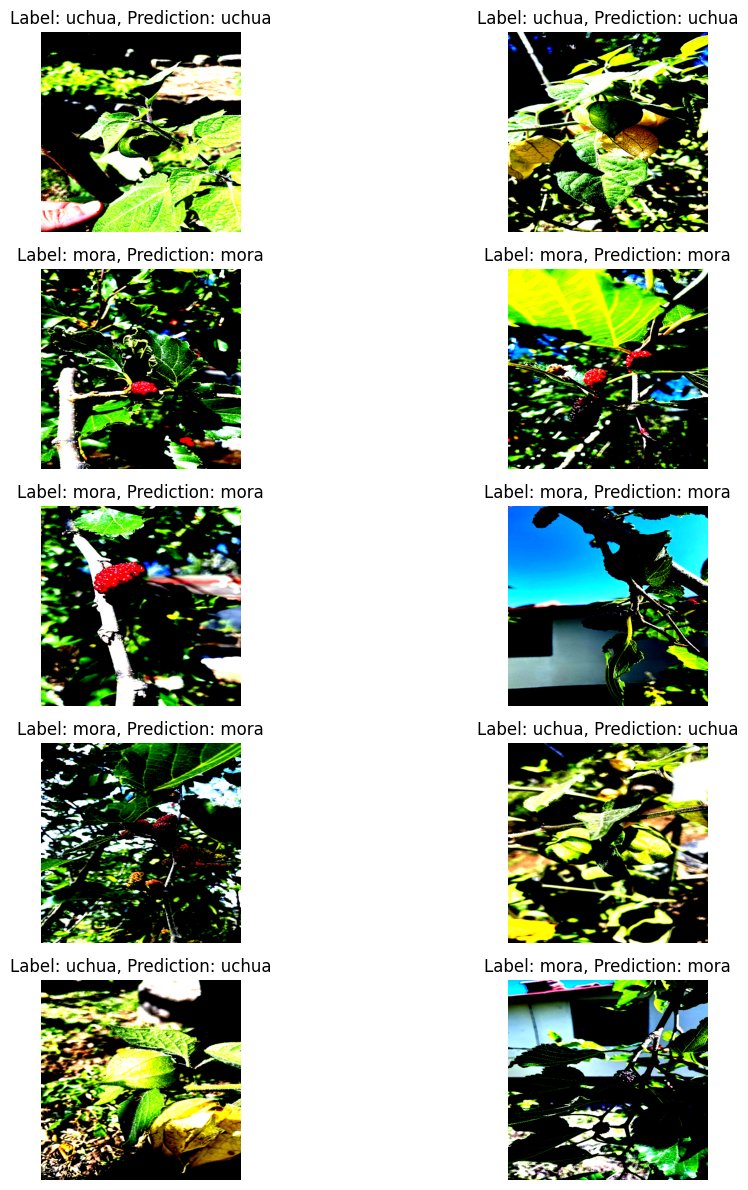

In [99]:
import matplotlib.pyplot as plt

def plot_results(model, test_loader, num_images=5, grid_cols=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    
    images_per_row = grid_cols
    grid_rows = (num_images + images_per_row - 1) // images_per_row
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            fig, axes = plt.subplots(grid_rows, images_per_row, figsize=(12, 12))
            fig.subplots_adjust(hspace=0.1)
            
            for j, ax in enumerate(axes.flat):
                if j < num_images:
                    image = np.clip(images[j].cpu().numpy().transpose((1, 2, 0)), 0, 1)
                    label = labels[j].item()
                    prediction = predicted[j].item()
                    
                    ax.imshow(image)
                    ax.set_axis_off()
                    ax.set_title(f"Label: {idx_to_class[label]}, Prediction: {idx_to_class[prediction]}")
                    
            plt.tight_layout()   
            plt.show()
            
            if (i+1) * test_loader.batch_size >= num_images:
                break

# Assuming you have the trained model available in the 'trained_model' variable
plot_results(trained_model, test_loader, num_images=10, grid_cols=2)


## Test on new images

In [100]:
torch.save(trained_model, 'fruit_model.pth')

In [115]:
data_dir = os.path.join('data', 'test_images')
test_transforms = transforms.Compose([transforms.Resize(512),
                                      transforms.ToTensor(),
                                     ])

In [154]:
model = torch.load('fruit_model.pth')

def predict_image(image_path, model, device):
    image = Image.open(image_path)
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor = image_tensor.to(device)
    
    output = model(image_tensor)
    index = output.data.cpu().numpy().argmax()
    
    plt.title(f'Prediction: {idx_to_class[index]}')
    plt.tight_layout()
    plt.imshow(image)
    



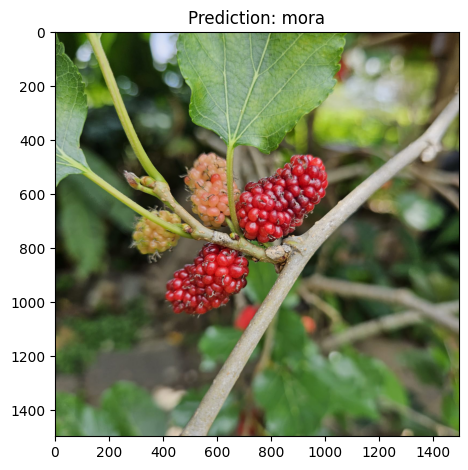

In [158]:
predict_image('data/test_images/WhatsApp Image 2023-06-04 at 19.25.59.jpeg', model, device)

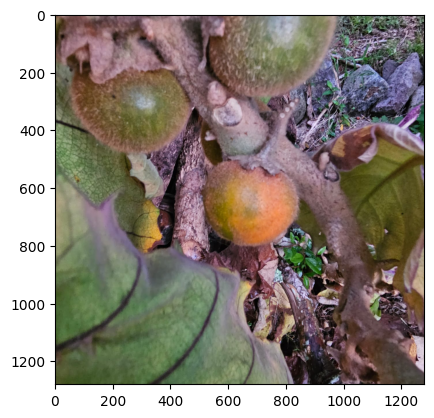